In [80]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image, ImageDraw
from ast import literal_eval
import matplotlib.pyplot as plt
import urllib

#progress bar for for-loop
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# 1) Installing Keras-RetinaNet

In [2]:
# !git clone https://github.com/fizyr/keras-retinanet.git

In [3]:
# %cd keras-retinanet/

# !pip install .

In [4]:
# !python setup.py build_ext --inplace

In [5]:
import tensorflow as tf
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

print(tf.__version__)

1.15.0


# 2) Preprocessing Data for Input to RetinaNet

In [6]:
train = pd.read_csv('./input/train.csv')
print('train.shape:', train.shape)
train.head()

train.shape: (147793, 5)


image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

### a) Convert annotation for RetinaNet (xbl,ybl,xtr,ytr)

In [7]:
def convert_annotation (df):
    '''Convert x,y,w,h to xbl,ybl,xtr,ytr
       e.g.""[834.0, 222.0, 56.0, 36.0]" to "834, 222, 890, 258, wheat"
    '''
    
    bboxs=[bbox[1:-1].split(', ') for bbox in df['bbox']]
    bboxs=[f"{int(float(bbox[0]))},{int(float(bbox[1]))},{int(float(bbox[0]))+int(float(bbox[2]))},{int(float(bbox[1]))+int(float(bbox[3]))},wheat" for bbox in bboxs]
    df['bbox_']=bboxs
    
    return df

In [8]:
train = convert_annotation(train)
train.head()

image_id  width  height                         bbox   source  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1   

                   bbox_  
0  834,222,890,258,wheat  
1  226,548,356,606,wheat  
2  377,504,451,664,wheat  
3   834,95,943,202,wheat  
4   26,144,150,261,wheat

In [9]:
train_df = train[['image_id','bbox_']]

print('train_df.shape:', train_df.shape)
train_df.head()

train_df.shape: (147793, 2)


image_id                  bbox_
0  b6ab77fd7  834,222,890,258,wheat
1  b6ab77fd7  226,548,356,606,wheat
2  b6ab77fd7  377,504,451,664,wheat
3  b6ab77fd7   834,95,943,202,wheat
4  b6ab77fd7   26,144,150,261,wheat

### b) Shuffle the data & Select 10% portion of data for trial training

In [10]:
train_df = train_df.sample(frac=0.1).reset_index(drop=True)

print('train_df.shape:', train_df.shape)
train_df.head()

train_df.shape: (14779, 2)


image_id                   bbox_
0  b1642dc6f   772,793,854,854,wheat
1  f0508910d  971,285,1024,365,wheat
2  4e5c1078d     43,17,167,103,wheat
3  8b67401f1  980,527,1024,576,wheat
4  0a3cb453f   215,417,293,520,wheat

# 2) Preparing Files to be given for training

### a) Annotation file 
contains all the path of all images and their corresponding bounding boxes (img_path, xbl, ybl, xtr, ytr, class_name)

In [11]:
with open("annotations.csv","w") as file:
    for idx in range(len(train_df)):
        file.write('./input/train/'+train_df.iloc[idx,0]+".jpg"+","+train_df.iloc[idx,1]+"\n")

### b) Class file
contains the number of classes but in our case it is just 1 (Wheat)

In [12]:
with open("classes.csv","w") as file:
    file.write("wheat,0")

# 3) Downloading the pretrained model

In [25]:
PRETRAINED_MODEL = './keras-retinanet/snapshots/_pretrained_model.h5'

# URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
# urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

# print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

# 4) Training Model

In [36]:
# Model Parameters

EPOCHS = 1
BATCH_SIZE = 1
STEPS = 100 # int(np.ceil(len(train_df)/BATCH_SIZE))
LR = 1e-3

* max batch size = 1 for gtx 1060 6G......

otherwises, exhausted

In [37]:
# The minimum required version is 1.14.0 (blacklisted: [(2, 0, 0), (2, 0, 1)])

!python keras-retinanet/keras_retinanet/bin/train.py --random-transform --weights {PRETRAINED_MODEL} --lr {LR} --batch-size {BATCH_SIZE} --steps {STEPS} --epochs {EPOCHS} --no-resize csv annotations.csv classes.csv

Creating model, this may take a second...

2020-05-27 14:55:38.200238: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors


Using TensorFlow backend.

tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors

tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors


Instructions for updating:

tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors

If using Keras pass *_constraint arguments to layers.

tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors

Model: "retinanet"



2020-05-27 14:55:44.866564: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll

__________________________________________________________________________________________________

2020-05-27 14:55:44.890808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 

Layer (type)                    Output Shape         Param #     Connected to                     

name: GeForce GTX 1060 6GB major: 6 minor: 1 memoryClockRate(GHz): 1.7845

pciBusID: 0000:01:00.0

input_1 (InputLayer)            (None, None, None, 3 0                                            

2020-05-27 14:55:44.891170: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll


__________________________________________________________________________________________________


2020-05-27 14:55:44.893815: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll

padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    

2020-05-27 14:55:44.896043: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_100.dll

__________________________________________________________________________________________________

2020-05-27 14:55:44.897141: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library curand64_100.dll

conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              

2020-05-27 14:55:44.900100: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusolver64_100.dll

__________________________________________________________________________________________________

2020-05-27 14:55:44.902569: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusparse64_100.dll

bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      

2020-05-27 14:55:44.908875: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudnn64_7.dll

__________________________________________________________________________________________________

2020-05-27 14:55:44.910028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Adding visible gpu devices: 0

conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   


__________________________________________________________________________________________________

2020-05-27 14:55:44.910500: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2

pool1 (MaxPooling2D)            (None, None, None, 6 0           conv1_relu[0][0]                 

2020-05-27 14:55:44.914143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 

__________________________________________________________________________________________________

name: GeForce GTX 1060 6GB major: 6 minor: 1 memoryClockRate(GHz): 1.7845

res2a_branch2a (Conv2D)         (None, None, None, 6 4096        pool1[0][0]                      

pciBusID: 0000:01:00.0

__________________________________________________________________________________________________

2020-05-27 14:55:44.914980: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll

bn2a_branch2a (BatchNormalizati (None, None, None, 6 256         res2a_branch2a[0][0]             

2020-05-27 14:55:44.915569: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll

__________________________________________________________________________________________________

2020-05-27 14:55:44.916145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_100.dll

res2a_branch2a_relu (Activation (None, None, None, 6 0           bn2a_branch2a[0][0]              

2020-05-27 14:55:44.916654: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library curand64_100.dll

__________________________________________________________________________________________________

2020-05-27 14:55:44.917280: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusolver64_100.dll

padding2a_branch2b (ZeroPadding (None, None, None, 6 0           res2a_branch2a_relu[0][0]        

2020-05-27 14:55:44.917906: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusparse64_100.dll

__________________________________________________________________________________________________

2020-05-27 14:55:44.918493: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudnn64_7.dll

res2a_branch2b (Conv2D)         (None, None, None, 6 36864       padding2a_branch2b[0][0]         

2020-05-27 14:55:44.920519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Adding visible gpu devices: 0

__________________________________________________________________________________________________

2020-05-27 14:55:45.483412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:

bn2a_branch2b (BatchNormalizati (None, None, None, 6 256         res2a_branch2b[0][0]             

2020-05-27 14:55:45.483742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      0 



__________________________________________________________________________________________________

2020-05-27 14:55:45.483937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 0:   N 



res2a_branch2b_relu (Activation (None, None, None, 6 0           bn2a_branch2b[0][0]              

2020-05-27 14:55:45.485182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1304] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 4708 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1)



__________________________________________________________________________________________________

D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 9) vs (720, 256, 3, 3)).


  weight_values[i].shape))

res2a_branch2c (Conv2D)         (None, None, None, 2 16384       res2a_branch2b_relu[0][0]        


__________________________________________________________________________________________________

D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((9,) vs (720,)).



res2a_branch1 (Conv2D)          (None, None, None, 2 16384       pool1[0][0]                      

  weight_values[i].shape))

__________________________________________________________________________________________________

Instructions for updating:

bn2a_branch2c (BatchNormalizati (None, None, None, 2 1024        res2a_branch2c[0][0]             

Use tf.where in 2.0, which has the same broadcast rule as np.where

__________________________________________________________________________________________________

bn2a_branch1 (BatchNormalizatio (None, None, None, 2 1024        res2a_branch1[0][0]              

__________________________________________________________________________________________________

2020-05-27 14:56:01.806921: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudnn64_7.dll

res2a (Add)                     (None, None, None, 2 0           bn2a_branch2c[0][0]              

2020-05-27 14:56:02.549732: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Internal: Invoking ptxas not supported on Windows


Relying on driver to perform ptx compilation. This message will be only logged once.

                                                                 bn2a_branch1[0][0]               

2020-05-27 14:56:02.711035: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll

__________________________________________________________________________________________________


res2a_relu (Activation)         (None, None, None, 2 0           res2a[0][0]                      


2020-05-27 14:56:05.026057: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.

__________________________________________________________________________________________________


2020-05-27 14:56:05.030077: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.

res2b_branch2a (Conv2D)         (None, None, None, 6 16384       res2a_relu[0][0]                 

2020-05-27 14:56:05.046044: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


2020-05-27 14:56:05.061707: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.

__________________________________________________________________________________________________


bn2b_branch2a (BatchNormalizati (None, None, None, 6 256         res2b_branch2a[0][0]             

2020-05-27 14:56:05.323908: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.

__________________________________________________________________________________________________

2020-05-27 14:56:06.140770: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.

res2b_branch2a_relu (Activation (None, None, None, 6 0           bn2b_branch2a[0][0]              

2020-05-27 14:56:06.151445: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.

__________________________________________________________________________________________________

D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `mAP` which is not available. Available metrics are: loss,regression_loss,classification_loss,lr

padding2b_branch2b (ZeroPadding (None, None, None, 6 0           res2b_branch2a_relu[0][0]        

  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning

__________________________________________________________________________________________________
res2b_branch2b (Conv2D)         (None, None, None, 6 36864       padding2b_branch2b[0][0]         
__________________________________________________________________________________________________
bn2b_branch2b (BatchNormalizati (None, None, None, 6 256         res2b_branch2b[0][0]             
__________________________________________________________________________________________________
res2b_branch2b_relu (Activation (None, None, None, 6 0           bn2b_branch2b[0][0]              
__________________________________________________________________________________________________
res2b_branch2c (Conv2D)         (None, None, None, 2 16384       res2b_branch2b_relu[0][0]        
__________________________________________________________________________________________________
bn2b_branch2c (BatchNormalizati (None, None, None, 2 1024        res2b_branch2c[0][0]             
__________

bn3b_branch2c (BatchNormalizati (None, None, None, 5 2048        res3b_branch2c[0][0]             
__________________________________________________________________________________________________
res3b (Add)                     (None, None, None, 5 0           bn3b_branch2c[0][0]              
                                                                 res3a_relu[0][0]                 
__________________________________________________________________________________________________
res3b_relu (Activation)         (None, None, None, 5 0           res3b[0][0]                      
__________________________________________________________________________________________________
res3c_branch2a (Conv2D)         (None, None, None, 1 65536       res3b_relu[0][0]                 
__________________________________________________________________________________________________
bn3c_branch2a (BatchNormalizati (None, None, None, 1 512         res3c_branch2a[0][0]             
__________

bn4b_branch2a (BatchNormalizati (None, None, None, 2 1024        res4b_branch2a[0][0]             
__________________________________________________________________________________________________
res4b_branch2a_relu (Activation (None, None, None, 2 0           bn4b_branch2a[0][0]              
__________________________________________________________________________________________________
padding4b_branch2b (ZeroPadding (None, None, None, 2 0           res4b_branch2a_relu[0][0]        
__________________________________________________________________________________________________
res4b_branch2b (Conv2D)         (None, None, None, 2 589824      padding4b_branch2b[0][0]         
__________________________________________________________________________________________________
bn4b_branch2b (BatchNormalizati (None, None, None, 2 1024        res4b_branch2b[0][0]             
__________________________________________________________________________________________________
res4b_bran

__________________________________________________________________________________________________
bn4e_branch2c (BatchNormalizati (None, None, None, 1 4096        res4e_branch2c[0][0]             
__________________________________________________________________________________________________
res4e (Add)                     (None, None, None, 1 0           bn4e_branch2c[0][0]              
                                                                 res4d_relu[0][0]                 
__________________________________________________________________________________________________
res4e_relu (Activation)         (None, None, None, 1 0           res4e[0][0]                      
__________________________________________________________________________________________________
res4f_branch2a (Conv2D)         (None, None, None, 2 262144      res4e_relu[0][0]                 
__________________________________________________________________________________________________
bn4f_branc

__________________________________________________________________________________________________
bn5c_branch2a (BatchNormalizati (None, None, None, 5 2048        res5c_branch2a[0][0]             
__________________________________________________________________________________________________
res5c_branch2a_relu (Activation (None, None, None, 5 0           bn5c_branch2a[0][0]              
__________________________________________________________________________________________________
padding5c_branch2b (ZeroPadding (None, None, None, 5 0           res5c_branch2a_relu[0][0]        
__________________________________________________________________________________________________
res5c_branch2b (Conv2D)         (None, None, None, 5 2359296     padding5c_branch2b[0][0]         
__________________________________________________________________________________________________
bn5c_branch2b (BatchNormalizati (None, None, None, 5 2048        res5c_branch2b[0][0]             
__________

 69/100 [===================>..........] - ETA: 20s - loss: 5.2964 - regression_loss: 2.4571 - classification_loss: 2.8393


100/100 [==============================] - 62s 619ms/step - loss: 5.6878 - regression_loss: 2.4800 - classification_loss: 3.2079

Epoch 00001: saving model to ./snapshots\resnet50_csv_01.h5


# 5) Loading the trained model

In [39]:
!dir snapshots

 磁碟區 D 中的磁碟沒有標籤。
 磁碟區序號:  2EB0-0FB4

 D:\LamFamily\Documents\jupyter-notebook\Kaggle\Global-Wheat-Detection\snapshots 的目錄

27/05/2020  14:56    <DIR>          .
27/05/2020  14:56    <DIR>          ..
27/05/2020  14:57       436,426,080 resnet50_csv_01.h5
               1 個檔案     436,426,080 位元組
               2 個目錄  137,905,524,736 位元組可用


In [41]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


# 6) Display prediction

In [69]:
# testing images

li = os.listdir('./input/test/')
li

['2fd875eaa.jpg',
 '348a992bb.jpg',
 '51b3e36ab.jpg',
 '51f1be19e.jpg',
 '53f253011.jpg',
 '796707dd7.jpg',
 'aac893a91.jpg',
 'cb8d261a3.jpg',
 'cc3532ff6.jpg',
 'f5a1f0358.jpg']

In [65]:
def predict(image):
    image = preprocess_image(image.copy())
    #image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    #boxes /= scale

    return boxes, scores, labels

In [66]:
THRES_SCORE = 0.5

def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{:.3f}".format(score)
        draw_caption(image, b, caption)

In [149]:
def show_detected_objects(image_name):
    img_path = './input/test/'+image_name
  
    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_detections(draw, boxes, scores, labels)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

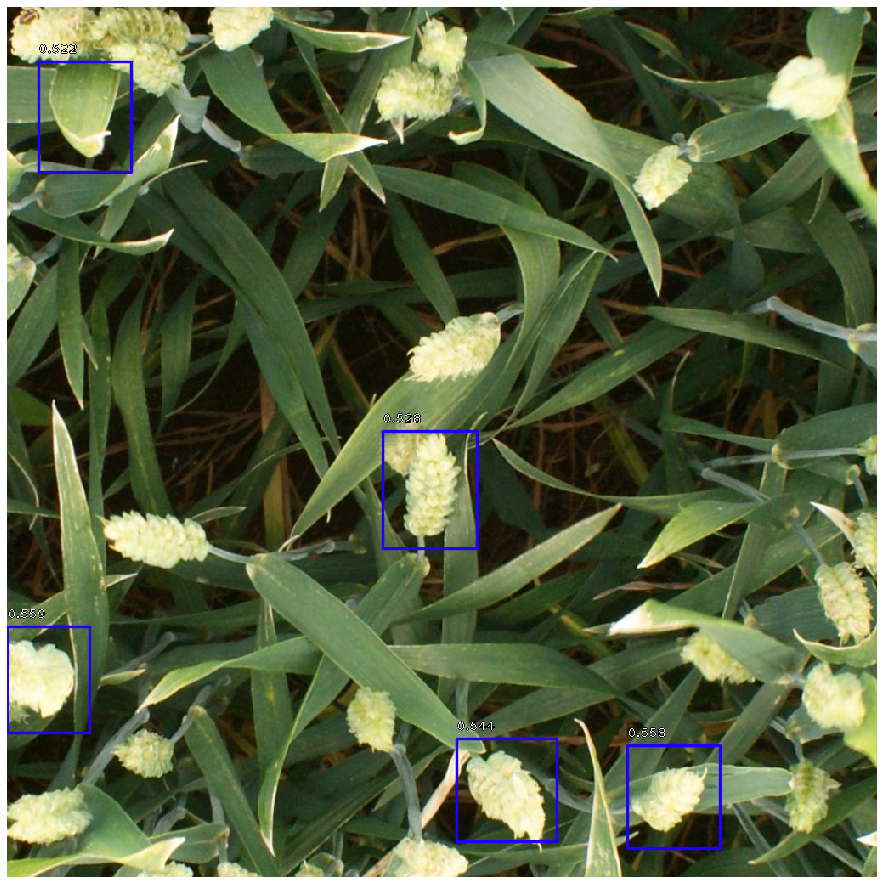

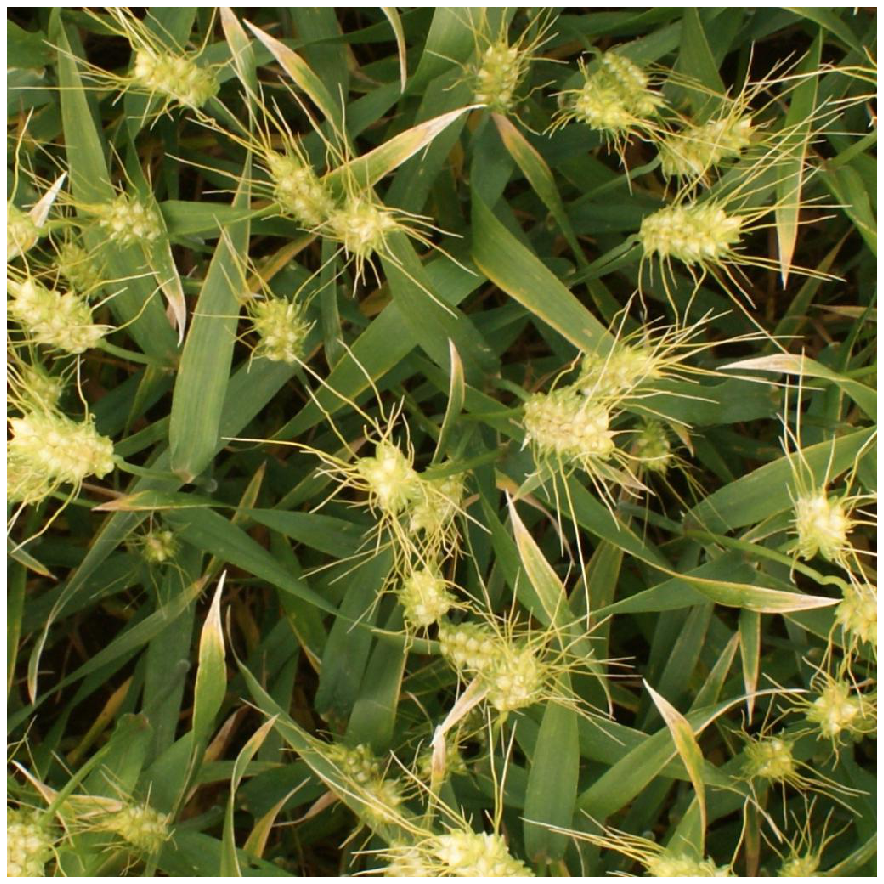

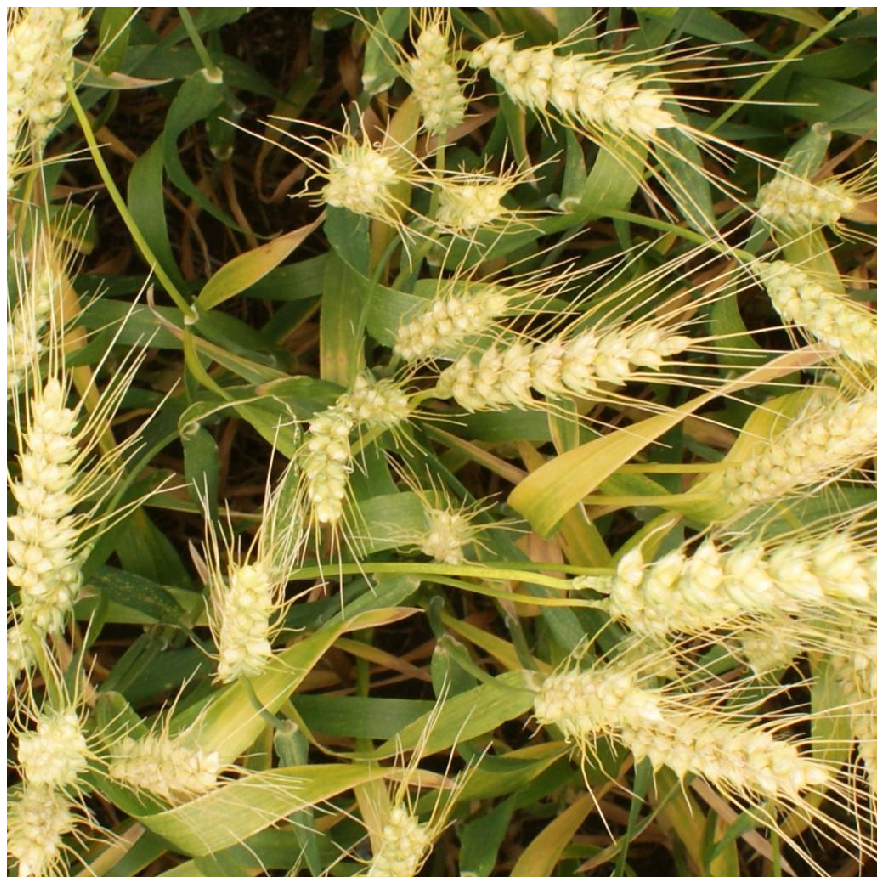

In [150]:
for img in li[:3]:
    show_detected_objects(img)

**Observations:**
* Didn't use whole training set for train due to limited gpu resources & time
* Therefore, only first testing image can be detected

In [108]:
# Predict all testing images

preds=[]
imgid=[]

for img in tqdm(li):   # for img in li:
    img_path = './input/test/'+img
    image = read_image_bgr(img_path)
    boxes, scores, labels = predict(image)
    boxes=boxes[0]
    scores=scores[0]
    for idx in range(boxes.shape[0]):
        if scores[idx]>THRES_SCORE:
            box,score=boxes[idx],scores[idx]
            imgid.append(img.split(".")[0])
            preds.append("{} {} {} {} {}".format(score, int(box[0]), int(box[1]), int(box[2]-box[0]), int(box[3]-box[1])))        

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


In [111]:
print('len(preds):', len(preds))
preds[0]

len(preds): 5


'0.5588699579238892 0 729 97 124'

In [112]:
submission={"image_id":imgid, "PredictionString":preds}
submission=pd.DataFrame(submission)

print('submission.shape:', submission.shape)
submission

submission.shape: (5, 2)


image_id                    PredictionString
0  2fd875eaa     0.5588699579238892 0 729 97 124
1  2fd875eaa   0.557945966720581 730 869 109 120
2  2fd875eaa  0.5440685749053955 529 861 117 121
3  2fd875eaa  0.5281500816345215 442 499 110 138
4  2fd875eaa    0.5223726630210876 37 64 108 130

# 7) Submission

In [129]:
submission1 = submission.groupby(["image_id"])['PredictionString'].apply(lambda x: ' '.join(x)).reset_index()
submission1

image_id                                   PredictionString
0  2fd875eaa  0.5588699579238892 0 729 97 124 0.557945966720...

In [140]:
sample_submission = pd.read_csv("./input/sample_submission.csv")

print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (10, 2)


image_id PredictionString
0  aac893a91    1.0 0 0 50 50
1  51f1be19e    1.0 0 0 50 50
2  f5a1f0358    1.0 0 0 50 50
3  796707dd7    1.0 0 0 50 50
4  51b3e36ab    1.0 0 0 50 50

In [144]:
final_submission = sample_submission.merge(submission1, on='image_id', how='left').drop('PredictionString_x', axis=1)
final_submission.columns = sample_submission.columns
final_submission

image_id                                   PredictionString
0  aac893a91                                                NaN
1  51f1be19e                                                NaN
2  f5a1f0358                                                NaN
3  796707dd7                                                NaN
4  51b3e36ab                                                NaN
5  348a992bb                                                NaN
6  cc3532ff6                                                NaN
7  2fd875eaa  0.5588699579238892 0 729 97 124 0.557945966720...
8  cb8d261a3                                                NaN
9  53f253011                                                NaN

In [146]:
sample_submission.to_csv('./final_submission.csv', index=False)